In [1]:
# importing the libraries
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
path = "./dataset/"
train_dataset = h5py.File(os.path.join(path,"train_catvnoncat.h5"),'r')
test_dataset = h5py.File(os.path.join(path,"test_catvnoncat.h5"),'r')

print('Column of train dataset:', list(train_dataset.keys()))
print('Column of test  dataset:', list(test_dataset.keys()))

Column of train dataset: ['list_classes', 'train_set_x', 'train_set_y']
Column of test  dataset: ['list_classes', 'test_set_x', 'test_set_y']


In [3]:
# process train data
train_x = np.array( train_dataset['train_set_x'] ) # train features
train_y = np.array( train_dataset['train_set_y'] ) # train label
train_classes = np.array( train_dataset['list_classes'] )

# process test data
test_x = np.array( test_dataset['test_set_x'] ) # test features
test_y = np.array( test_dataset['test_set_y'] ) # test label
test_classes = np.array( test_dataset['list_classes'] ) # list of classes


# rehspae the label
train_y = train_y.reshape((1, train_y.shape[0]))
test_y = test_y.reshape( (1, test_y.shape[0]) )

# since classes are same for both train and test
classes = train_classes

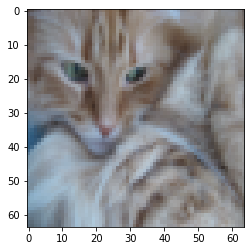

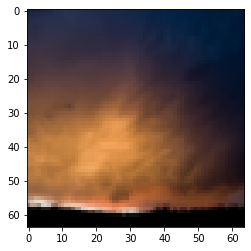

In [4]:
plt.imshow(train_x[2])
plt.show()

plt.imshow(train_x[0])
plt.show()

In [5]:
print(train_x.shape)

(209, 64, 64, 3)


In [6]:
# flattened each image into a column vector
X_train = train_x.reshape((train_x.shape[0],-1)).T
X_test = test_x.reshape((test_x.shape[0],-1)).T

In [7]:
print(X_train.shape)
print(X_test.shape)
print(train_y.shape)
print(test_y.shape)

(12288, 209)
(12288, 50)
(1, 209)
(1, 50)


In [8]:
# normalising the images
X_train = X_train/255
X_test = X_test/255
print(X_train.max())
print(X_test.max())

1.0
1.0


In [9]:
# function for parameter initialisation
def initialization(layerdims):
    np.random.seed(2)
    parameters = {}
    nl = len(layerdims)
    for i in range(1,nl):
        name = "W"+str(i)
        parameters[name] = np.random.randn(layerdims[i],layerdims[i-1])/np.sqrt(layerdims[i])
        name = "B"+str(i)
        parameters[name] = np.zeros((layerdims[i],1))
    return parameters

In [10]:
# defining activation function 
# using Leaky relu function for hidden layers and sigmoid function for output layer
def activation(x1,kind):
    x = x1.astype('float64')
    dif = None
    if kind == "relu":
        dif = np.ones(x.shape)
        dif[x<=0] = 0.01
        x[x<0] = 0.01*x[x<0]
    elif kind == "sigmoid":
        x = 1/(1+np.exp(-x))
        dif = x*(1-x)
    elif kind == "tanh":
        x = np.tanh(x)
        dif = (1- x**2)
    return x,dif

In [11]:
# forward propagation
def forward(parameters,x1):
    cache = {}
    x = x1.astype('float64')
    nl = len(parameters)//2
    cache["a0"] = copy.deepcopy(x)
    for i in range(1,nl):
        name = "W"+str(i)
        x = np.dot(parameters[name],x)+parameters["B"+str(i)]
        cache["z"+str(i)] = copy.deepcopy(x)
        x,dif = activation(x,"relu")
        cache["a"+str(i)] = copy.deepcopy(x)
        cache["dg"+str(i)] = dif
    x = np.dot(parameters["W"+str(nl)],x)+parameters["B"+str(nl)]
    cache["z"+str(nl)] = copy.deepcopy(x)
    x,dif = activation(x,"sigmoid")
    cache["a"+str(nl)] = copy.deepcopy(x)


    return x,cache

In [12]:
# defining cost function
def cost(y_pred,y,parameters,lambd):
    m = y.shape[1]
    loss = (-1/m)*np.sum(np.multiply(y,np.log(y_pred))+np.multiply(1-y,np.log(1-y_pred)),axis=1,keepdims = True)
    for i in range(0,len(parameters)//2):
        temp = lambd*np.sum(np.sum(np.power(parameters["W"+str(i+1)],2),axis = 1,keepdims=True),axis = 0,keepdims=True)
        loss += temp/m
    loss = np.squeeze(loss)
    return loss

In [13]:
# defining back propogation
def backward(y,y_pred,cache,parameters,lambd):
    layer = len(parameters)//2
    grad = {}
    dz = y_pred-y
    m = y.shape[1]
    for i in range(layer,0,-1):
        grad["dw"+str(i)] = (1/m)*np.dot(dz,cache["a"+str(i-1)].T) + (lambd/m)*parameters["W"+str(i)]
        grad["db"+str(i)] = (1/m)*np.sum(dz,axis = 1,keepdims=True)
        if i > 1:
            dz = np.dot(parameters["W"+str(i)].T,dz)
            dz = np.multiply(dz,cache["dg"+str(i-1)])

    return grad


In [14]:
# update parameters
def update_parameters(parameters,grad,learning_rate):
    layers = len(parameters)//2
    p = {}
    for i in range(1,layers+1):
        p["W"+str(i)] = parameters["W"+str(i)] - learning_rate*grad["dw"+str(i)]
        p["B"+str(i)] = parameters["B"+str(i)] - learning_rate*grad["db"+str(i)]
    return p

In [15]:
# neural model
def neural_network_model(x,out,layerdims,iterations,learning_rate,lambd):
    # initialising parameters
    parameters = initialization(layerdims)
    costs = []
    # generating y for current catagory
    y = out
    iter = 0
    while iter < iterations:
        y_pred,cache = forward(parameters,x)
        if iter%100 == 0:
            costs.append(cost(y_pred,y,parameters,lambd))
        if iter%100== 0:
            print("iterations executed = ",iter)
        grad = backward(y,y_pred,cache,parameters,lambd)
        parameters = update_parameters(parameters,grad,learning_rate)
        iter += 1
    print("Done")
    return parameters,costs

In [16]:
# function to predict
def predict(x,y,parameters):
    y_pred,cache = forward(parameters,x)
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    y_pred = y_pred.astype("int")
    y_pred = np.squeeze(y_pred)
    y = np.squeeze(y)
    print("confusion matrix :")
    print(confusion_matrix(y,y_pred))
    print("Accuracy = ",accuracy_score(y,y_pred))

In [17]:
# setting neural networks parameters
n_h = 10 # number of units in hidden layers
n_l = 10 # number of hidden layers
n_o = 1 # number of unit in output layer
n_x = X_train.shape[0]

In [18]:
n_h = 30
print("No of units in hidden layer = ",n_h)
n_layers = 4
LayerDims = [n_x]
for i in range(0,n_layers):
    LayerDims.append(n_h)
LayerDims.append(n_o)
Parameters,Costs = neural_network_model(X_train,train_y,LayerDims,3500,0.005,22)

No of units in hidden layer =  30
iterations executed =  0
iterations executed =  100
iterations executed =  200
iterations executed =  300
iterations executed =  400
iterations executed =  500
iterations executed =  600
iterations executed =  700
iterations executed =  800
iterations executed =  900
iterations executed =  1000
iterations executed =  1100
iterations executed =  1200
iterations executed =  1300
iterations executed =  1400
iterations executed =  1500
iterations executed =  1600
iterations executed =  1700
iterations executed =  1800
iterations executed =  1900
iterations executed =  2000
iterations executed =  2100
iterations executed =  2200
iterations executed =  2300
iterations executed =  2400
iterations executed =  2500
iterations executed =  2600
iterations executed =  2700
iterations executed =  2800
iterations executed =  2900
iterations executed =  3000
iterations executed =  3100
iterations executed =  3200
iterations executed =  3300
iterations executed =  340

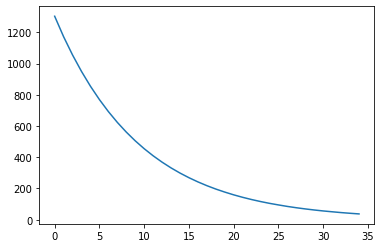

In [19]:
plt.plot(Costs)

In [20]:
predict(X_train,train_y,Parameters)

confusion matrix :
[[136   1]
 [  0  72]]
Accuracy =  0.9952153110047847


In [21]:
predict(X_test,test_y,Parameters)

confusion matrix :
[[13  4]
 [ 4 29]]
Accuracy =  0.84
